In [1]:
!pip install python-louvain

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import community

In [9]:
df = pd.read_csv('criptomonedasv2.csv')

In [10]:
df.head()

,Nombre,Simbolo,Valor USD,Capitalizacion de mercado,Volumen en 24h,Porcentaje del volumen diario,Suministro circulante,Suministro total,Suministro máximo,Etiquetas
0,Bitcoin,BTC,60391.910074,1.192966e+12,3.232494e+10,-4.2815,1.975373e+07,1.975373e+07,21000000.0,"mineable, pow, sha-256, store-of-value, state-..."
1,Ethereum,ETH,2441.886798,2.938387e+11,1.373839e+10,13.3063,1.203326e+08,1.203326e+08,NaN,"pos, smart-contracts, ethereum-ecosystem, coin..."
2,Tether USDt,USDT,1.000655,1.184043e+11,5.037031e+10,1.9914,1.183267e+11,1.202378e+11,NaN,"stablecoin, asset-backed-stablecoin, avalanche..."
3,BNB,BNB,556.182464,8.116600e+10,1.767894e+09,4.1890,1.459341e+08,1.459341e+08,NaN,"marketplace, centralized-exchange, payments, s..."
4,Solana,SOL,138.586615,6.487425e+10,1.659380e+09,3.8867,4.681134e+08,5.844517e+08,NaN,"pos, platform, solana-ecosystem, cms-holdings-..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Nombre                         1011 non-null   object 
 1   Simbolo                        1011 non-null   object 
 2   Valor USD                      1011 non-null   float64
 3   Capitalizacion de mercado      1011 non-null   float64
 4   Volumen en 24h                 1011 non-null   float64
 5   Porcentaje del volumen diario  1011 non-null   float64
 6   Suministro circulante          1011 non-null   float64
 7   Suministro total               1011 non-null   float64
 8   Suministro máximo              536 non-null    float64
 9   Etiquetas                      919 non-null    object 
dtypes: float64(7), object(3)
memory usage: 79.1+ KB


In [6]:
df.isnull().sum()

Nombre                             0
Simbolo                            0
Valor USD                          0
Capitalizacion de mercado          0
Volumen en 24h                     0
Porcentaje del volumen diario      0
Suministro circulante              0
Suministro total                   0
Suministro máximo                475
Etiquetas                         92
dtype: int64

In [11]:
#Reemplazamos valores nulos por un numero alto porque algunas criptomonedas no tienen limite.
df['Suministro máximo'].fillna(np.inf, inplace=True)

C:\Users\emily\AppData\Local\Temp\ipykernel_13004\3501468242.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Suministro máximo'].fillna(np.inf, inplace=True)


In [12]:
#Agregar columna booleana si tiene o no suministro maximo
df['Tiene_SM'] = df['Suministro máximo'].notnull().astype(int)

In [13]:
#Normalizamos las variables numericas
variables = ['Valor USD', 'Capitalizacion de mercado', 'Volumen en 24h',
             'Porcentaje del volumen diario', 'Suministro circulante','Tiene_SM']
scaler = StandardScaler()
X = scaler.fit_transform(df[variables])

In [14]:
#Calculamos la matriz de similitud
similaridad = cosine_similarity(X)

In [15]:
k = 5  #Vecinos mas cercanos
g= nx.Graph()

#Agregar los nodos
for index, row in df.iterrows():
    g.add_node(row['Nombre'], **row.to_dict())


In [16]:
#Agregar las aristas basadas en los k vecinos más cercanos
for i in range(len(df)):
    indices_vecinos = np.argsort(-similaridad[i])[1:k+1]
    for j in indices_vecinos:
        g.add_edge(df.iloc[i]['Nombre'], df.iloc[j]['Nombre'], weight=similaridad[i][j])

In [17]:
#Comunidades
partition = community.best_partition(g)
nx.set_node_attributes(g, partition, 'comunidad')

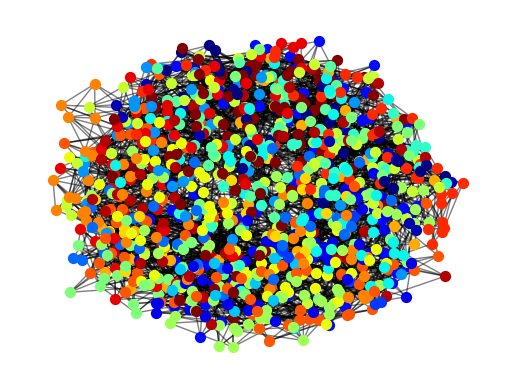

In [18]:
#Encontrar la posicion de los nodos
pos = nx.spring_layout(g, k=0.15, iterations=20)

#Encontrar comunidades
comunidades = set(partition.values())

colores = plt.cm.jet(np.linspace(0, 1, len(comunidades)))
colores_map = {}
for comunidad, color in zip(comunidades, colores):
    colores_map[comunidad] = color

for nodo in g.nodes():
    nx.draw_networkx_nodes(g, pos, [nodo], node_size=50, node_color=[colores_map[partition[nodo]]])

#Dibujar
nx.draw_networkx_edges(g, pos, alpha=0.5)

plt.axis('off')
plt.show()